# Solving a Lid-Driven Cavity Flow with Scalar Mixing

_Highlights_
- solving the two-dimensional incompressible Navier-Stokes equations with a vorticity-streamfunction method
- solving a scalar transport equation
- using Spitfire `odesolve` to solve this problem with several methods:
  - the Forward Euler method
  - the Shu-Osher "strong stability preserving" RK method
  - and a fourth-order method using adaptive time-stepping


## Introduction

The [Navier-Stokes equations](https://en.wikipedia.org/wiki/Navier–Stokes_equations) are an incredibly important system of partial differential equations that describe the motion of a variety of fluids, the flickering candle flames to and air flow over planes and missiles at high speeds. Computational fluid dynamics (CFD) is the use of numerical methods and computers to build models of fluid flow for science and engineering. A common assumption used to simplify the equations for many flows is that the fluid is [incompressible](https://en.wikipedia.org/wiki/Incompressible_flow).

Time-dependent incompressible flows in two dimensions can be solved very conveniently with the vorticity-streamfunction formulation. In this demonstration we use this formulation and several explicit methods in Spitfire, including an SSPRK method defined in this notebook, to solve a two-dimensional lid-driven cavity flow. The lid-driven cavity is a canonical flow for CFD solvers and it is often used for code validation. The setup is quite simple - an incompressible fluid is contained in a box and the upper wall of the box is moved horizontally at a constant velocity. Depending on the type of fluid, this produces a large central vortex and a cascade of turbulent motions.



In [1]:
import numpy as np
from time import perf_counter
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import splu

In [25]:
class LidDrivenCavity:
    def __init__(self, n, Re, Sc, dt_factor, scheme, stage_velocity_update=False):
        print('Initializing lid driven cavity...')
        self._n = n
        self._n2 = n * n
        x = np.linspace(0., 1, self._n)
        y = np.linspace(0., 1, self._n)
        xg, yg = np.meshgrid(x, y)
        self._xgrid = np.copy(xg)
        self._ygrid = np.copy(yg)
        
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        self._invdx = 1. / dx
        self._invdy = 1. / dy
        self._invdx2 = self._invdx * self._invdx
        self._invdy2 = self._invdy * self._invdy
        
        self._Re = Re
        self._Sc = Sc
        self._invRe = 1. / Re
        self._invSc = 1. / Sc
        
        self._dt = dt_factor * np.min([dx * dx * Re, 1. / Re])
        
        Ae = self._invdx2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        Aw = self._invdx2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        As = self._invdy2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        An = self._invdy2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        Ap = -(Aw + Ae + An + As)
        Ae[:,-1] = 0.
        Aw[:,0] = 0.
        An[-1,:] = 0.
        As[0,:] = 0.
        nn = (self._n - 2) * (self._n - 2)
        d0 = Ap.reshape(nn)
        de = Ae.reshape(nn)[:-1]
        dw = Aw.reshape(nn)[1:]
        ds = As.reshape(nn)[(self._n - 2):]
        dn = An.reshape(nn)[:-(self._n - 2)]
        psi_lhs_op = diags([d0, de, dw, dn, ds], [0, 1, -1, (self._n - 2), -(self._n - 2)], format='csc')
        self._psi_inv_op = splu(psi_lhs_op)
        self._psi_wall = 0.
        
        self._psi = np.zeros_like(self._xgrid)
        self._vx = np.zeros_like(self._xgrid[1:-1, 1:-1])
        self._vy = np.zeros_like(self._xgrid[1:-1, 1:-1])
        self._w0 = np.zeros_like(self._xgrid)
        self._z0 = np.zeros_like(self._xgrid)
        
        self._limiter = {'upwind': 'upwind',
                         'central': 'central',
                         'minmod': self._minmod}[scheme]
        
        self._stage_velocity_update = stage_velocity_update
        
        print('Done initializing. Don\'t forget to set z0 to the desired initial scalar profile.')
    
    @property
    def xgrid(self):
        return self._xgrid
    
    @property
    def ygrid(self):
        return self._ygrid
    
    @property
    def z0(self):
        return self._z0
    
    @z0.setter
    def z0(self, z0vals):
        self._z0 = np.copy(z0vals)
        self._z0[0,:] = self._z0[1,:]
        self._z0[-1,:] = self._z0[-2,:]
        self._z0[:,0] = self._z0[:,1]
        self._z0[:,-1] = self._z0[:,-2]
    
    @property
    def initial_state(self):
        return np.hstack((self._w0.ravel(), self._z0.ravel()))
    
    @property
    def dt(self):
        return self._dt
    
    def _apply_w_bcs(self, w, psi):
        w[:,0] = 2.0 * (self._psi_wall - self._psi[:,1]) * self._invdx2
        w[:,-1] = 2.0 * (self._psi_wall - self._psi[:,-2]) * self._invdx2
        w[0,:] = 2.0 * (self._psi_wall - self._psi[1,:]) * self._invdy2
        w[-1,:] = 2.0 * (self._psi_wall - self._psi[-2,:]) * self._invdy2 - 2.0 * self._invdy
        
    def _apply_scalar_bcs(self, z):
        z[0,:] = z[1,:]
        z[-1,:] = z[-2,:]
        z[:,0] = z[:,1]
        z[:,-1] = z[:,-2]
        
    def _minmod(self, r):
        return np.maximum(0., np.minimum(1., r))
    
    def _update_velocities(self, w):
        self._psi[1:-1, 1:-1] = self._psi_inv_op.solve(-w[1:-1, 1:-1].ravel()).reshape([self._n - 2, self._n - 2])
        self._vx = 0.5 * (self._psi[2:,1:-1] - self._psi[:-2,1:-1]) * self._invdy
        self._vy = -0.5 * (self._psi[1:-1,2:] - self._psi[1:-1,:-2]) * self._invdx
    
    def pre_step(self, t, state, *args, **kwargs):
        if not self._stage_velocity_update:
            print('pre step')
            w = np.reshape(state[:self._n2], (self._n, self._n))
            self._update_velocities(w)
    
    def _compute_transport_rhs(self, vx, vy, limiter, q, coeff):
        qe = q[1:-1,2:]
        qw = q[1:-1,:-2]
        qs = q[:-2,1:-1]
        qn = q[2:,1:-1]
        qp = q[1:-1,1:-1]
        if limiter is 'central':
            qx = 0.5 * self._invdx * (qe - qw)
            qy = 0.5 * self._invdy * (qn - qs)
        elif limiter is 'upwind':
            qx = self._invdx * np.where(vx < 0., qe - qp, qp - qw)
            qy = self._invdy * np.where(vy < 0., qn - qp, qp - qs)
        else:
            qxc = 0.5 * self._invdx * (qe - qw)
            qyc = 0.5 * self._invdy * (qn - qs)
            qxu = self._invdx * np.where(vx < 0., qe - qp, qp - qw)
            qyu = self._invdy * np.where(vy < 0., qn - qp, qp - qs)
            phix = limiter((qp - qw) / ((qe - qp) + 1.e-6))
            phiy = limiter((qp - qs) / ((qn - qp) + 1.e-6))
            qx = qxu - phix * (qxu - qxc)
            qy = qyu - phiy * (qyu - qyc)
        
        qxx = (qe - 2. * qp + qw) * self._invdx2
        qyy = (qn - 2. * qp + qs) * self._invdy2
        
        rhs = np.zeros_like(self._xgrid)
        rhs[1:-1,1:-1] = - vx * qx - vy * qy + coeff * (qxx + qyy)
        return rhs.ravel()
    
    def rhs(self, t, state):
        w = np.reshape(state[:self._n2], (self._n, self._n))
        z = np.reshape(state[self._n2:], (self._n, self._n))
        
        if self._stage_velocity_update:
            self._update_velocities(w)
        
        self._apply_w_bcs(w, self._psi)
        self._apply_scalar_bcs(z)
        
        rhs = np.zeros_like(state)
        rhs[:self._n2] = self._compute_transport_rhs(self._vx, self._vy, self._limiter, w, self._invRe)
        rhs[self._n2:] = self._compute_transport_rhs(self._vx, self._vy, self._limiter, z, self._invRe * self._invSc)
        
        return rhs
    
    def extract_wz(self, state):
        if len(state.shape) > 1:
            w = state[:, :self._n2].reshape((state.shape[0], self._n, self._n))
            z = state[:, self._n2:].reshape((state.shape[0], self._n, self._n))
        else:
            w = state[:self._n2].reshape((self._n, self._n))
            z = state[self._n2:].reshape((self._n, self._n))
        return w, z

In [32]:
n = 128
Re = 1000.
Sc = 100.

flow = LidDrivenCavity(n, Re, Sc, dt_factor=1., scheme='minmod', stage_velocity_update=True)

flow.z0[np.logical_and(np.logical_and(flow.xgrid > 0.25, flow.xgrid < 0.75), 
                       np.logical_and(flow.ygrid > 0.25, flow.ygrid < 0.75))] = 1.0
# flow.z0[np.logical_and(flow.xgrid > 0.25, flow.xgrid < 0.75)] = 1.0

Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.


In [ ]:
from spitfire import odesolve, PIController, AdaptiveERK54CashKarp

tf = 60.

output_times = np.linspace(0, tf, 200)

states = odesolve(flow.rhs, 
                  flow.initial_state,
                  output_times, 
                  step_size=PIController(first_step=flow.dt, 
                                         target_error=1e-2, 
                                         max_step=1.e3 * flow.dt), 
                  method=AdaptiveERK54CashKarp(), 
                  verbose=True, 
                  log_rate=400,
                  pre_step_callback=flow.pre_step)

w, z = flow.extract_wz(states)


 2020-03-29 23:12 : Spitfire running case with method: Adaptive ERK 5(4) Cash-Karp

|number of  | simulation | time step  | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | |residual| | time (s)   | step (ms)|
---------------------------------------------------------------------------|
| 400       | 3.50e+00   | 1.19e-02   | 6.08e+00   | 9.91e+00   | 2.48e+01 |
| 800       | 6.70e+00   | 6.37e-03   | 2.11e+00   | 1.99e+01   | 2.48e+01 |
| 1200      | 1.04e+01   | 9.73e-03   | 9.70e+00   | 3.04e+01   | 2.53e+01 |
| 1600      | 1.33e+01   | 8.94e-03   | 7.35e+00   | 4.10e+01   | 2.56e+01 |


<IPython.core.display.Javascript object>


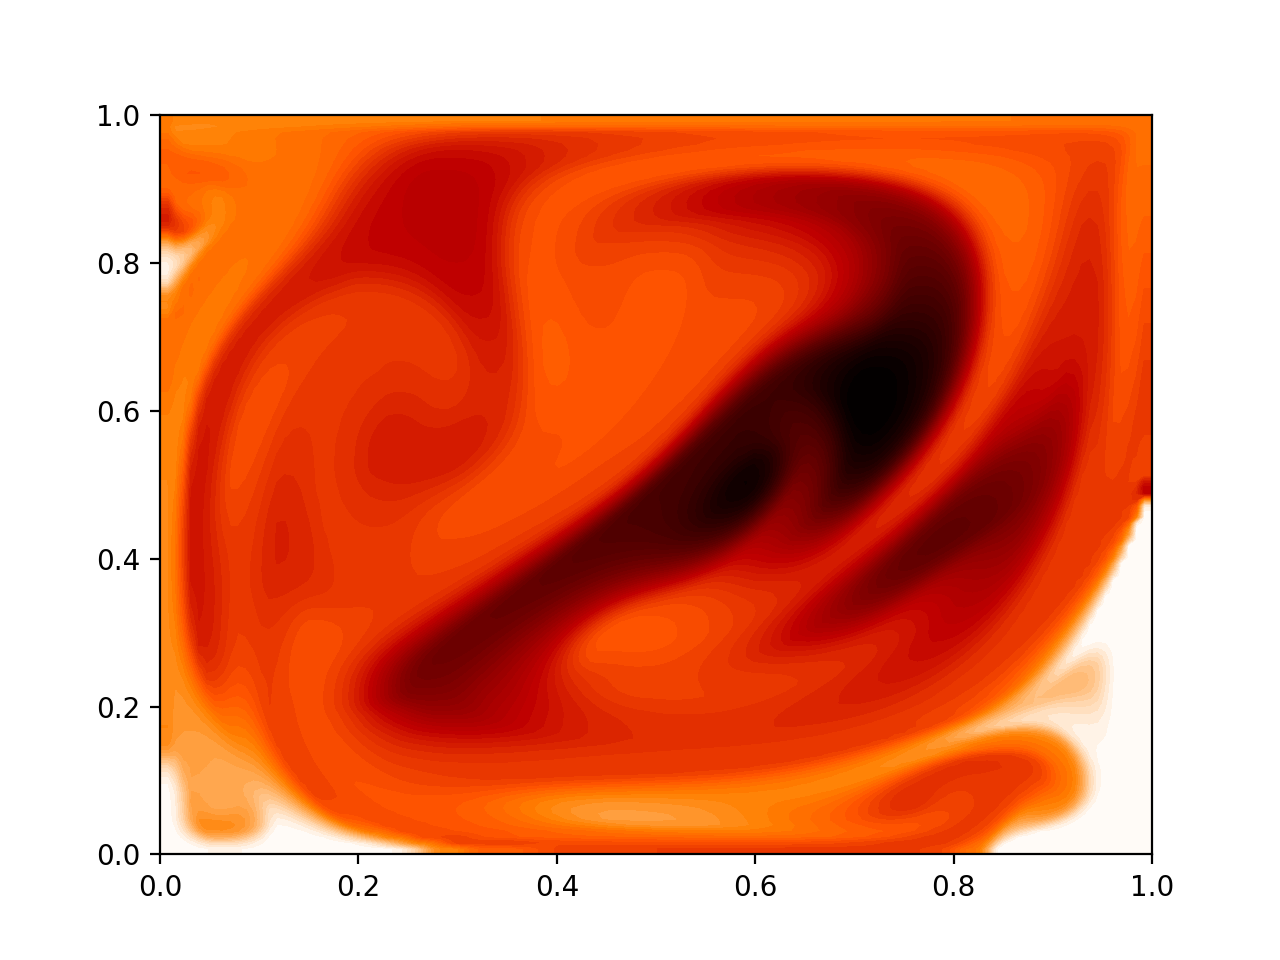

In [10]:
import matplotlib.pyplot as plt

%matplotlib notebook
plt.contourf(flow.xgrid, flow.ygrid, z[-1, :, :], 64, cmap='gist_heat_r')
# plt.streamplot(flow.xgrid[1:-1, 1:-1], flow.ygrid[1:-1, 1:-1], flow._vx, flow._vy)
plt.show()

In [12]:
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

def movie(v, cmap, save_to_file=None):
    fig, ax = plt.subplots()

    ax.contourf(flow.xgrid, flow.ygrid, v[0, :, :], 64, cmap=cmap)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    def animate(i):
        ax.collections = []
        ax.cla()
        ax.contourf(flow.xgrid, flow.ygrid, v[i, :, :], 64, cmap=cmap)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')

    anim = FuncAnimation(fig, animate, interval=1, frames=v.shape[0])
    
    if save_to_file is not None:
        anim.save(save_to_file, dpi=1200)

    return anim

<IPython.core.display.Javascript object>


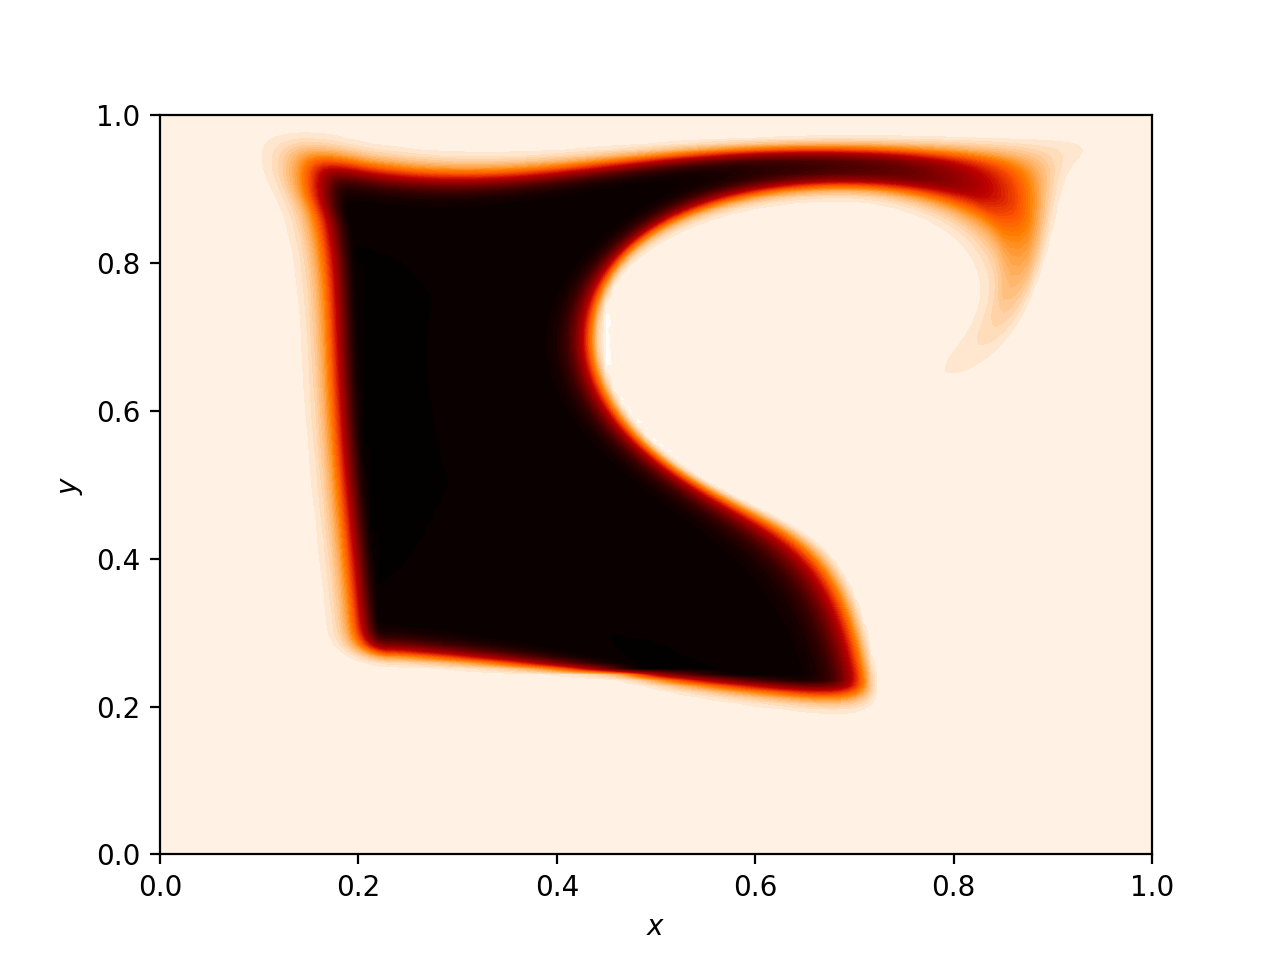

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from ipywidgets import interact, widgets

%matplotlib notebook
m = movie(z, 'gist_heat_r')#, 'Re40k_Sc10_512x512.mov')

# cm = 'gist_heat_r'
# 
# %matplotlib notebook
# plt.contourf(xgrid, ygrid, z_sol[:, :, 0], levels=np.linspace(0, 1.01, 64), norm=Normalize(0, 1), cmap=cm)
# plt.xlim([0, Lx])
# plt.ylim([0, Ly])
# plt.grid()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.tight_layout()
# 
# def f(it):
#     plt.contourf(xgrid, ygrid, z_sol[:, :, it], levels=np.linspace(0, 1.01, 64), norm=Normalize(0, 1), cmap=cm)

# interact(f, it=widgets.IntSlider(min=0, max=ntsaved - 1, step=1, value=0));

Traceback (most recent call last):
  File "/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/opt/anaconda3/envs/spitfire/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


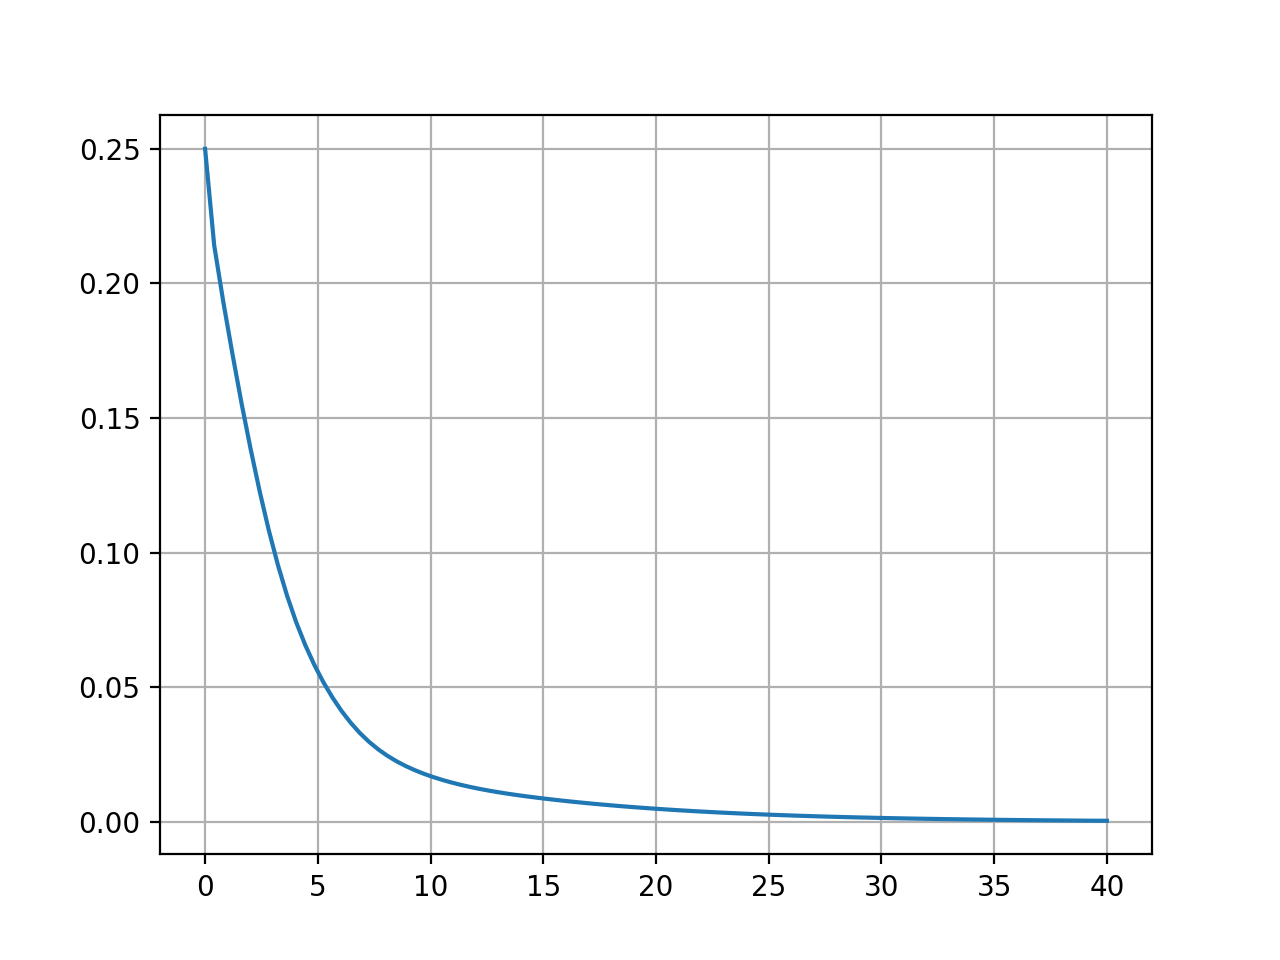

In [11]:
zvariance = np.zeros(output_times.size)

for i in range(output_times.size):
    zvariance[i] = np.var(z[i, :, :].ravel())

%matplotlib notebook
plt.plot(output_times, zvariance)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


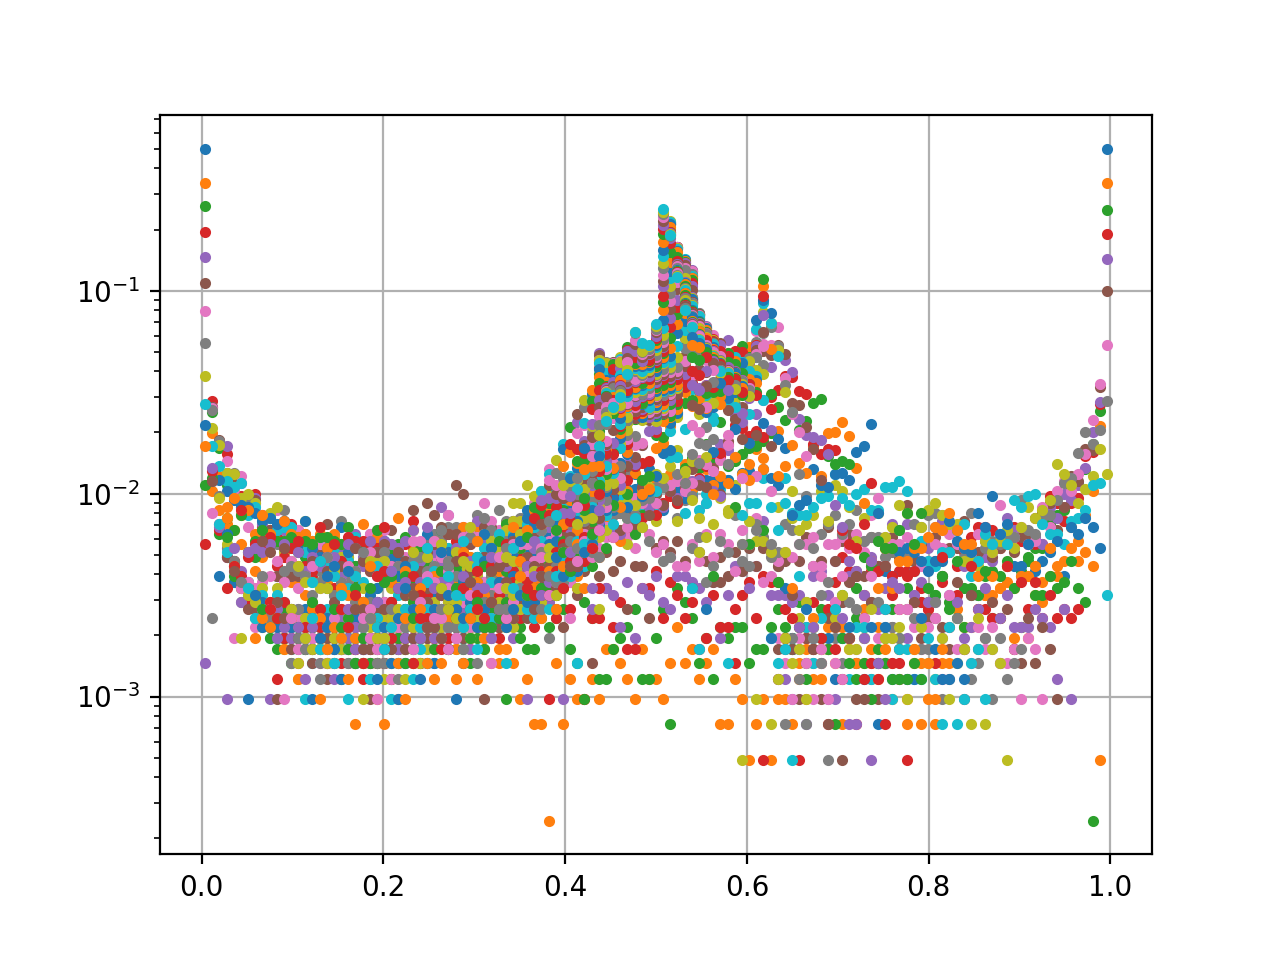

In [12]:
zpdfs = []

bins = np.linspace(0, 1, 128)
bincenters = 0.5 * (bins[1:] + bins[:-1])
for i in range(output_times.size):
    h = np.histogram(z[i, :, :].ravel(), bins=bins)
    zpdfs.append(h[0])

%matplotlib notebook

for zp in zpdfs:
    plt.plot(bincenters, zp / np.sum(zp), '.')
plt.grid()
plt.yscale('log')

<IPython.core.display.Javascript object>


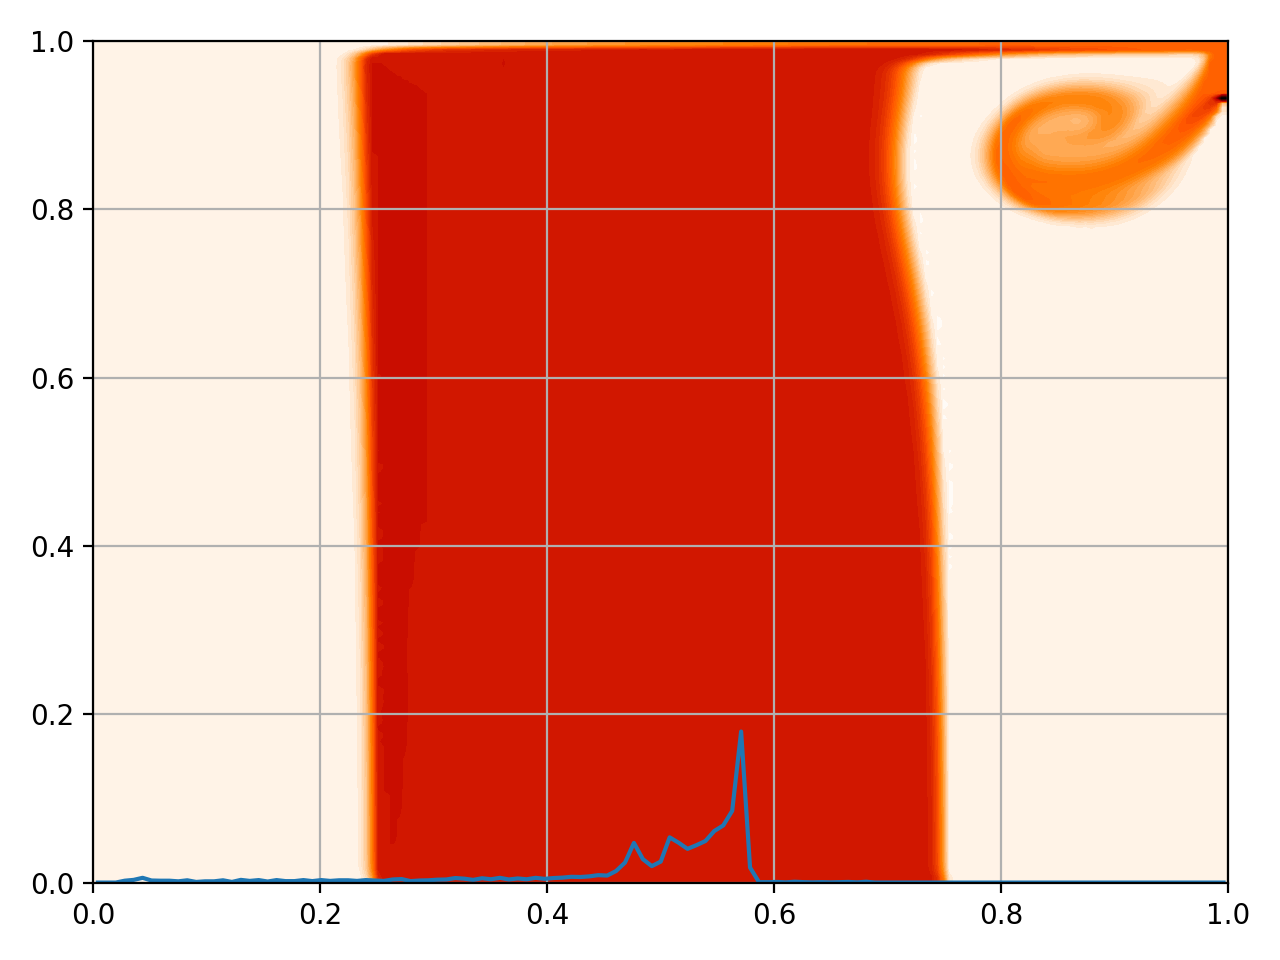

interactive(children=(IntSlider(value=0, description='it', max=99), Output()), _dom_classes=('widget-interact'…

In [14]:
%matplotlib notebook
l, = plt.plot(bincenters, zpdfs[0] / np.sum(zpdfs[0]))
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

def f(it):
    l.set_ydata(zpdfs[it] / np.sum(zpdfs[it]))

interact(f, it=widgets.IntSlider(min=0, max=len(zpdfs) - 1, step=1, value=0));